# Some summary plots

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib_venn import venn2, venn2_circles
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import decoupler as dc

In [2]:
from pathlib import Path
import os

In [3]:
root_dir = "/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/L6_CT/"
os.chdir(root_dir)
figure_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_figures/new_summary_20250324/")

In [4]:
direct_table = pd.read_csv("scplus_outputs/eRegulon_direct.tsv", sep="\t", header=0)
extend_table = pd.read_csv("scplus_outputs/eRegulons_extended.tsv", sep="\t", header=0)
regulons_table = pd.concat([direct_table, extend_table], axis=0)
regulons_table.reset_index(drop=True, inplace=True)
regulons_table = regulons_table[regulons_table["eRegulon_name"].str.endswith("+/+")].copy()

In [5]:
RC_positive_peak_table = pd.read_csv(
    "../other_celltypes/corr_regions_5e-1_5e-2_expr_filtered/L6_CT_positive.tsv",
    sep="\t", header=None
)
RC_positive_peak_table.columns = ["Region"]
RC_negative_peak_table = pd.read_csv(
    "../other_celltypes/corr_regions_5e-1_5e-2_expr_filtered/L6_CT_negative.tsv",
    sep="\t", header=None
)
RC_negative_peak_table.columns = ["Region"]
RC_positive_peak_table["Region"] = RC_positive_peak_table.apply(
    lambda x: ":".join(x["Region"].split("-", 1)), axis=1)
RC_negative_peak_table["Region"] = RC_negative_peak_table.apply(
    lambda x: ":".join(x["Region"].split("-", 1)), axis=1)

In [6]:
RC_corr_table = pd.read_csv(
    "../other_celltypes/corr_genes_7e-1_1e-2_expr_filtered/L6_CT_RC_table.tsv",
    header=0, sep="\t"
)

In [7]:
ST_positive_peak_table = pd.read_csv(
    "../other_celltypes/corr_regions_ST_5e-1_5e-2_expr_filtered/L6_CT_positive.tsv",
    sep="\t", header=None
)
ST_positive_peak_table.columns = ["Region"]
ST_negative_peak_table = pd.read_csv(
    "../other_celltypes/corr_regions_ST_5e-1_5e-2_expr_filtered/L6_CT_negative.tsv",
    sep="\t", header=None
)
ST_negative_peak_table.columns = ["Region"]
ST_positive_peak_table["Region"] = ST_positive_peak_table.apply(
    lambda x: ":".join(x["Region"].split("-", 1)), axis=1)
ST_negative_peak_table["Region"] = ST_negative_peak_table.apply(
    lambda x: ":".join(x["Region"].split("-", 1)), axis=1)

In [8]:
ST_corr_table = pd.read_csv(
    "../other_celltypes/corr_genes_ST_7e-1_1e-2_expr_filtered/L6_CT_RC_table.tsv",
    header=0, sep="\t"
)

In [9]:
RC_positive_edges = pd.merge(regulons_table, RC_positive_peak_table, on="Region", how="inner")
RC_negative_edges = pd.merge(regulons_table, RC_negative_peak_table, on="Region", how="inner")

In [10]:
ST_positive_edges = pd.merge(regulons_table, ST_positive_peak_table, on="Region", how="inner")
ST_negative_edges = pd.merge(regulons_table, ST_negative_peak_table, on="Region", how="inner")

# Plot the enhancers and target genes

In [11]:
atac_object = sc.read_h5ad("L6_CT_atac_matrix.h5ad")
atac_region_counts = dc.get_pseudobulk(
    adata=atac_object,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    min_prop=0.0,
    min_smpls=0,
    remove_empty=True,
    mode="sum"
)
sc.pp.normalize_total(atac_region_counts, target_sum=1e6)
sc.pp.log1p(atac_region_counts, base=2)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## RC

In [12]:
region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]

In [13]:
RC_pe = RC_positive_edges["Region"].to_list()
RC_pe = ["-".join(xx.split(":")) for xx in RC_pe]
RC_ne = RC_negative_edges["Region"].to_list()
RC_ne = ["-".join(xx.split(":")) for xx in RC_ne]
RC_enhancers = RC_pe + RC_ne
plot_matrix = atac_region_counts[region_align, RC_enhancers].X.T.copy()
row_means = np.mean(plot_matrix, axis=1, keepdims=True)
row_stds = np.std(plot_matrix, axis=1, keepdims=True)
plot_matrix_z = (plot_matrix - row_means) / row_stds

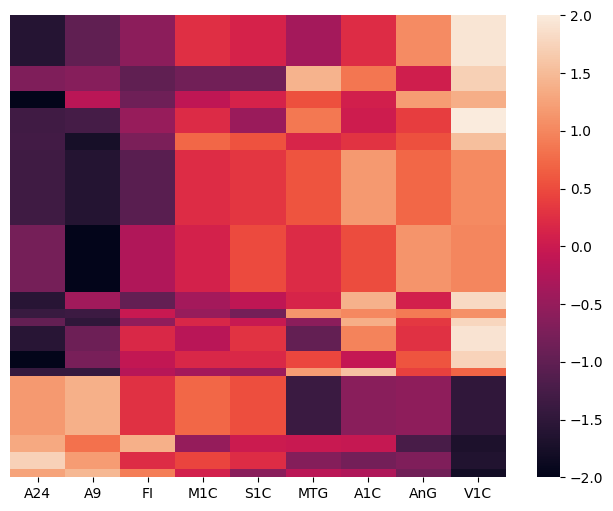

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.heatmap(
    plot_matrix_z,
    xticklabels=region_align,
    yticklabels=[],
    vmin=-2,
    vmax=2,
    ax=ax
)
fig.savefig(figure_dir / "L6_CT-RC-atac.pdf", dpi=300, format="pdf")

In [15]:
RC_corr_table["group1"] = "null"
RC_corr_table_null = RC_corr_table.copy()
RC_corr_table.loc[RC_corr_table["gene"].isin(set(RC_positive_edges["Gene"])), "group1"] = "positive_enhancer"
RC_corr_table_pos = RC_corr_table[RC_corr_table["group1"].isin(["positive_enhancer"])].copy()
RC_corr_table.loc[RC_corr_table["gene"].isin(set(RC_negative_edges["Gene"])), "group1"] = "negative_enhancer"
RC_corr_table_neg = RC_corr_table[RC_corr_table["group1"].isin(["negative_enhancer"])].copy()
plot_table = pd.concat([RC_corr_table_null, RC_corr_table_pos, RC_corr_table_neg])
del RC_corr_table["group1"]

In [16]:
from scipy.stats import mannwhitneyu
group_null = plot_table[plot_table["group1"] == "null"]["corr"]
group_pos = plot_table[plot_table["group1"] == "positive_enhancer"]["corr"]
group_neg = plot_table[plot_table["group1"] == "negative_enhancer"]["corr"]

stat_pos, p_pos = mannwhitneyu(group_pos, group_null)
print(f"Rank-sum test result for positive enhancers: stats: {stat_pos}, p value: {p_pos}")
stat_neg, p_neg = mannwhitneyu(group_null, group_neg)
print(f"Rank-sum test result for negative enhancers: stats: {stat_neg}, p value: {p_neg}")

Rank-sum test result for positive enhancers: stats: 288912.5, p value: 1.5067993611367067e-06
Rank-sum test result for negative enhancers: stats: 99262.0, p value: 0.0028628113809475984


null                 22431
positive_enhancer       15
negative_enhancer        5
Name: group1, dtype: int64


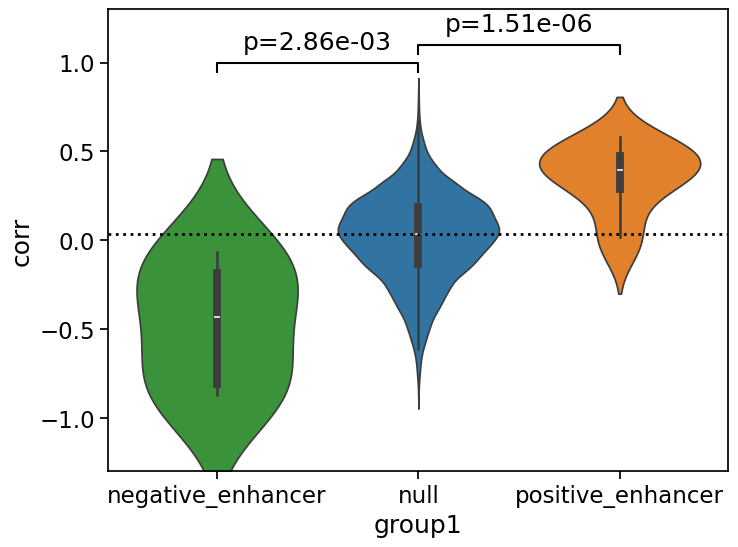

In [17]:
sns.set_context("notebook", font_scale=1.5)
print(plot_table["group1"].value_counts())
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.violinplot(
    plot_table, x="group1", y="corr", hue="group1", 
    order=["negative_enhancer", "null", "positive_enhancer"], ax=ax
)
null_median = np.median(group_null)
ax.axhline(null_median, color="black", linestyle="dotted", linewidth=2)
ax.set_ylim(-1.3, 1.3)
def add_bracket(x1, x2, y, pvalue, h, ax):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color="black")
    ax.text((x1+x2)/2, y+2*h, f"p={pvalue:.2e}", ha="center", va="bottom")
bracket_base = np.max(plot_table["corr"])
add_bracket(0, 1, bracket_base+0.1, p_neg, 0.05, ax)
add_bracket(1, 2, bracket_base+0.2, p_pos, 0.05, ax)
fig.savefig(figure_dir / "L6_CT-RC-target-genes.pdf", dpi=300, format="pdf")

## ST

In [18]:
region_align = ["A24", "A9", "FI", "MTG", "AnG", "M1C", "S1C", "A1C", "V1C"]

In [19]:
ST_pe = ST_positive_edges["Region"].to_list()
ST_pe = ["-".join(xx.split(":")) for xx in ST_pe]
ST_ne = ST_negative_edges["Region"].to_list()
ST_ne = ["-".join(xx.split(":")) for xx in ST_ne]
ST_enhancers = ST_pe + ST_ne
plot_matrix = atac_region_counts[region_align, ST_enhancers].X.T.copy()
row_means = np.mean(plot_matrix, axis=1, keepdims=True)
row_stds = np.std(plot_matrix, axis=1, keepdims=True)
plot_matrix_z = (plot_matrix - row_means) / row_stds

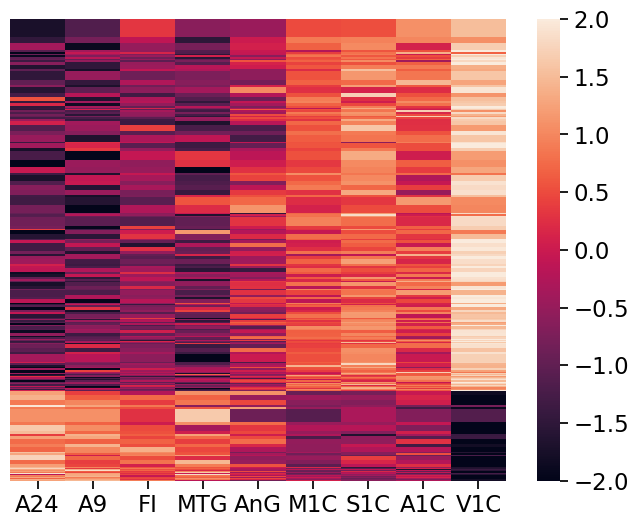

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.heatmap(
    plot_matrix_z,
    xticklabels=region_align,
    yticklabels=[],
    vmin=-2,
    vmax=2,
    ax=ax
)
fig.savefig(figure_dir / "L6_CT-ST-atac.pdf", dpi=300, format="pdf")

In [21]:
ST_corr_table["group1"] = "null"
ST_corr_table_null = ST_corr_table.copy()
ST_corr_table.loc[ST_corr_table["gene"].isin(set(ST_positive_edges["Gene"])), "group1"] = "positive_enhancer"
ST_corr_table_pos = ST_corr_table[ST_corr_table["group1"].isin(["positive_enhancer"])].copy()
ST_corr_table.loc[ST_corr_table["gene"].isin(set(ST_negative_edges["Gene"])), "group1"] = "negative_enhancer"
ST_corr_table_neg = ST_corr_table[ST_corr_table["group1"].isin(["negative_enhancer"])].copy()
plot_table = pd.concat([ST_corr_table_null, ST_corr_table_pos, ST_corr_table_neg])
del ST_corr_table["group1"]

In [22]:
from scipy.stats import mannwhitneyu
group_null = plot_table[plot_table["group1"] == "null"]["corr"]
group_pos = plot_table[plot_table["group1"] == "positive_enhancer"]["corr"]
group_neg = plot_table[plot_table["group1"] == "negative_enhancer"]["corr"]

stat_pos, p_pos = mannwhitneyu(group_pos, group_null)
print(f"Rank-sum test result for positive enhancers: stats: {stat_pos}, p value: {p_pos}")
stat_neg, p_neg = mannwhitneyu(group_null, group_neg)
print(f"Rank-sum test result for negative enhancers: stats: {stat_neg}, p value: {p_neg}")

Rank-sum test result for positive enhancers: stats: 2897899.5, p value: 2.534681841843441e-44
Rank-sum test result for negative enhancers: stats: 803232.5, p value: 3.812338039849947e-21


null                 22431
positive_enhancer      157
negative_enhancer       38
Name: group1, dtype: int64


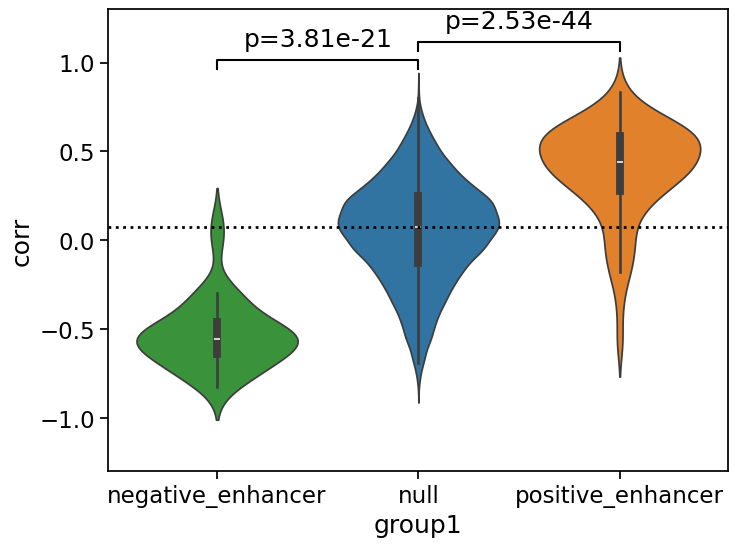

In [23]:
sns.set_context("notebook", font_scale=1.5)
print(plot_table["group1"].value_counts())
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.violinplot(
    plot_table, x="group1", y="corr", hue="group1", 
    order=["negative_enhancer", "null", "positive_enhancer"], ax=ax
)
null_median = np.median(group_null)
ax.axhline(null_median, color="black", linestyle="dotted", linewidth=2)
ax.set_ylim(-1.3, 1.3)
def add_bracket(x1, x2, y, pvalue, h, ax):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color="black")
    ax.text((x1+x2)/2, y+2*h, f"p={pvalue:.2e}", ha="center", va="bottom")
bracket_base = np.max(plot_table["corr"])
add_bracket(0, 1, bracket_base+0.1, p_neg, 0.05, ax)
add_bracket(1, 2, bracket_base+0.2, p_pos, 0.05, ax)
fig.savefig(figure_dir / "L6_CT-ST-target-genes.pdf", dpi=300, format="pdf")

# Wilcox test for all TF regulons

## RC

In [24]:
RC_atac_corr_table = pd.read_csv(
    "../other_celltypes/corr_regions_5e-1_5e-2_expr_filtered/L6_CT_RC_table.tsv",
    sep="\t", header=0
)
RC_atac_corr_table["region"] = RC_atac_corr_table.apply(
    lambda x: ":".join(x["region"].split("-", 1)), axis=1)

In [25]:
corr_lists = []
all_enhancer_corr = RC_atac_corr_table.loc[
    RC_atac_corr_table["region"].isin(regulons_table["Region"].to_list()), ["region", "corr"]].copy()
all_enhancer_corr["label"] = "null"
corr_lists.append(all_enhancer_corr)
for ctf in regulons_table["TF"].unique():
    ctf_enhancers = regulons_table[regulons_table["TF"] == ctf]["Region"].to_list()
    ctf_corr = RC_atac_corr_table.loc[RC_atac_corr_table["region"].isin(ctf_enhancers), ["region", "corr"]].copy()
    ctf_corr["label"] = ctf
    corr_lists.append(ctf_corr)

In [26]:
median_null = np.median(corr_lists[0]["corr"])
medians_all = [np.median(xx["corr"]) for xx in corr_lists]
sorted_indices = np.argsort(medians_all)
plot_corr_table = pd.concat([corr_lists[ii] for ii in sorted_indices], axis=0)

In [27]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
rank_sum_test_result = dict()
median_diff_result = dict()
for factor_name in plot_corr_table["label"].unique():
    if factor_name == "null":
        continue
    values_null = plot_corr_table[plot_corr_table["label"] == "null"]["corr"]
    values_curr = plot_corr_table[plot_corr_table["label"] == factor_name]["corr"]
    stats_curr, p_curr = mannwhitneyu(values_curr, values_null)
    rank_sum_test_result[factor_name] = p_curr
    median_diff_result[factor_name] = np.median(values_curr) - np.median(values_null)
keys = rank_sum_test_result.keys()
pvalues = np.array(list(rank_sum_test_result.values()))
adjusted_p = multipletests(pvalues, method="fdr_bh")[1]
rank_sum_test_result = {k: v for k, v in zip(keys, adjusted_p)}

In [28]:
RC_result_df = pd.DataFrame({
    "median_diff": median_diff_result,
    "adjusted_p": rank_sum_test_result
})
RC_result_df.to_csv(figure_dir / "L6_CT-RC-TF-activity.tsv", header=True, sep="\t", index=True)

## ST

In [29]:
ST_atac_corr_table = pd.read_csv(
    "../other_celltypes/corr_regions_ST_5e-1_5e-2_expr_filtered/L6_CT_ST_table.tsv",
    sep="\t", header=0
)
ST_atac_corr_table["region"] = ST_atac_corr_table.apply(
    lambda x: ":".join(x["region"].split("-", 1)), axis=1)

In [30]:
corr_lists = []
all_enhancer_corr = ST_atac_corr_table.loc[
    ST_atac_corr_table["region"].isin(regulons_table["Region"].to_list()), ["region", "corr"]].copy()
all_enhancer_corr["label"] = "null"
corr_lists.append(all_enhancer_corr)
for ctf in regulons_table["TF"].unique():
    ctf_enhancers = regulons_table[regulons_table["TF"] == ctf]["Region"].to_list()
    ctf_corr = ST_atac_corr_table.loc[ST_atac_corr_table["region"].isin(ctf_enhancers), ["region", "corr"]].copy()
    ctf_corr["label"] = ctf
    corr_lists.append(ctf_corr)

In [31]:
median_null = np.median(corr_lists[0]["corr"])
medians_all = [np.median(xx["corr"]) for xx in corr_lists]
sorted_indices = np.argsort(medians_all)
plot_corr_table = pd.concat([corr_lists[ii] for ii in sorted_indices], axis=0)

In [32]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
rank_sum_test_result = dict()
median_diff_result = dict()
for factor_name in plot_corr_table["label"].unique():
    if factor_name == "null":
        continue
    values_null = plot_corr_table[plot_corr_table["label"] == "null"]["corr"]
    values_curr = plot_corr_table[plot_corr_table["label"] == factor_name]["corr"]
    stats_curr, p_curr = mannwhitneyu(values_curr, values_null)
    rank_sum_test_result[factor_name] = p_curr
    median_diff_result[factor_name] = np.median(values_curr) - np.median(values_null)
keys = rank_sum_test_result.keys()
pvalues = np.array(list(rank_sum_test_result.values()))
adjusted_p = multipletests(pvalues, method="fdr_bh")[1]
rank_sum_test_result = {k: v for k, v in zip(keys, adjusted_p)}

In [33]:
ST_result_df = pd.DataFrame({
    "median_diff": median_diff_result,
    "adjusted_p": rank_sum_test_result
})
ST_result_df.to_csv(figure_dir / "L6_CT-ST-TF-activity.tsv", header=True, sep="\t", index=True)